# Import of libraries + Dataset

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report, confusion_matrix

from xgboost import XGBClassifier

import plotly.express as px

from IPython.display import display

In [2]:
dataset = pd.read_csv('conversion_data_train.csv')

# Data Visualization

In [3]:
print("Number of rows : {}".format(dataset.shape[0]))
print("Number of columns : {}".format(dataset.shape[1]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 284580
Number of columns : 6

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [4]:
# Removing lines with age value over 100, probably a mistake
dataset = dataset[dataset["age"] < 100]

# Preprocessing

In [5]:
# Separating target variable Y from features X
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = "converted"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

In [6]:
# Dividing dataset Train set & Test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)

In [7]:
# Separating numeric from categorical features
numeric_features = ['age','total_pages_visited']
categorical_features = ['country','new_user', 'source']

In [8]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), # no missing value on our dataset, but we might have some on new data to analyze
                                        ('scaler', StandardScaler())])

# Create pipeline for categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                            ('encoder', OneHotEncoder(drop='first'))])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [9]:
# Preprocessings on train set and test set
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Model 3: XGBoost

In [10]:
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2,4,6],
    'min_child_weight': [4,8,12], 
    'n_estimators': [75,100,125] 
}

gridsearch = GridSearchCV(xgboost, param_grid = params, cv = 5) 
gridsearch.fit(X_train, Y_train)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'max_depth': 2, 'min_child_weight': 8, 'n_estimators': 100}
Best validation accuracy :  0.9862471547700867


In [11]:
# Predictions on training set and on test set (to be able to evaluate with F1_score afterwards)
Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on training set :  0.7638637733574443
f1-score on test set :  0.7600836570062743


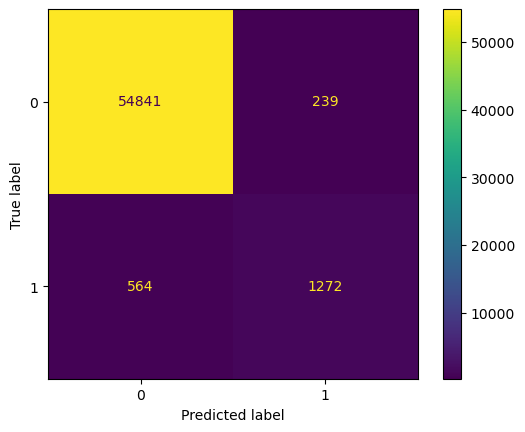

In [12]:
# Visualizing confusion matrix on test set
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test)

# Training model on all data and dumping prediction file

In [13]:
# Concatenating our train and test set to train the best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

gridsearch.fit(X,Y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max

In [14]:
# Reading data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')

In [17]:
# # Checking consistency of features_list (must be the same than the features used by the best classifier), OK
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

In [18]:
X_without_labels = preprocessor.transform(X_without_labels)

In [19]:
# Making predictions and dumping to file
data = {'converted': gridsearch.predict(X_without_labels)}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_model-3.csv', index=False)